##### Steps to detect duration and frequency of ball bouncing from wav file
1. Import necessary libraries
2. Open audio File
3. Detect periods of activity
4. For Each period, find the frequency of the ball
5. Output: 
    1. Plot a graph identifying periods of activity 
    2. Plot a sample period sinsoidal wave over activity
    3. Output excel file with columns: start period, end period, duration, frequency, number of bounces

1. Import necessary libraries

In [9]:
from pydub import AudioSegment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub.utils import mediainfo
import numpy, scipy.optimize
import pandas as pd
import os
from pydub.playback import play

2. Open audio File

In [10]:
MINIMUM_BOUNCES_TO_ADD_TO_RESULTS=5
SHOW_FIGURES=False
SHOW_DEBUG_MESSAGES=False
INITIAL_WINDOW_SIZE=1000
PERCENTILE_LEVEL = 80
FIG_SIZE = [18, 8]
SOUND_FILES_FOLDER = './sound_files'
ORIGINALS_SUB_FOLDER = 'originals'
FILE_NAME_ONLY_DICT = {'original_work_file': 'sound_of_ball_original.wav',
                       'file_with_breathing': 'pep4_2nd_original.mp3', 'fifth_file': 'AUD-20231221-WA0007_5th.m4a'}
FILE_NAME_ONLY=FILE_NAME_ONLY_DICT['fifth_file']
FILE_NAME = os.path.join(SOUND_FILES_FOLDER, ORIGINALS_SUB_FOLDER, FILE_NAME_ONLY)
info = mediainfo(FILE_NAME)
original_sample_rate=int(info['sample_rate'])
sound = AudioSegment.from_file(FILE_NAME)
# some files are stereo, then select the channel with higher power
if info['channels'] == '2':  # stereo
    sound_split = sound.split_to_mono()
    if sound_split[0].dBFS > sound_split[1].dBFS:
        sound = sound_split[0]
    else:
        sound = sound_split[1]

samples = sound.get_array_of_samples()
samples_list=samples.tolist()

In [11]:
sound_louder = sound+10
if SHOW_FIGURES:
    plt.figure(figsize=FIG_SIZE)
    _=plt.plot(samples_list, alpha=.5, color='blue', label='Original Signal')
    _=plt.plot(sound_louder.get_array_of_samples().tolist(), alpha=0.1, color='red', label='Magnified signal')
    plt.legend(loc='best')

3. Detect periods of activity

In [12]:
import time
start_time=time.time()
# 80 th percentile and window size of 1000 are good estimates
samples_list = sound_louder.get_array_of_samples().tolist()
window_size = INITIAL_WINDOW_SIZE
abs_samples_list = [abs(ele) for ele in samples_list]
abs_samples_list_pd = pd.Series(abs_samples_list)
req_percentile = np.percentile(abs_samples_list, PERCENTILE_LEVEL)
max_val = max(abs_samples_list)
# [f(x) if condition else g(x) for x in sequence]
signal_on = [max_val if x > req_percentile else 0 for x in abs_samples_list]
block_signal_on_slow = signal_on.copy()
block_signal_on = signal_on.copy()
print('elapsed time:', time.time()-start_time)

elapsed time: 2.193908929824829


In [5]:
start_time=time.time()
fast_i=window_size+1
high_val_list = [max_val]*2*window_size
while fast_i<len(samples_list)-window_size:
    if signal_on[fast_i]==max_val:
        block_signal_on[fast_i-window_size:fast_i+window_size]=high_val_list
        fast_i+=window_size
    else:
        fast_i+=1
print('elapsed time:', time.time()-start_time)

elapsed time: 0.8320057392120361


In [6]:


for i in range(window_size, len(samples_list)-window_size):
    if max_val in signal_on[i-window_size:i+window_size]:
        block_signal_on_slow[i]=max_val
if SHOW_FIGURES:
    plt.figure(figsize=FIG_SIZE,dpi=600)
    plt.plot(samples_list, label='Original signal')
    plt.plot(block_signal_on,'g', label='Blocks of activity')
    plt.legend(loc='best')
    plt.show()

False
3286016
3286016
13429


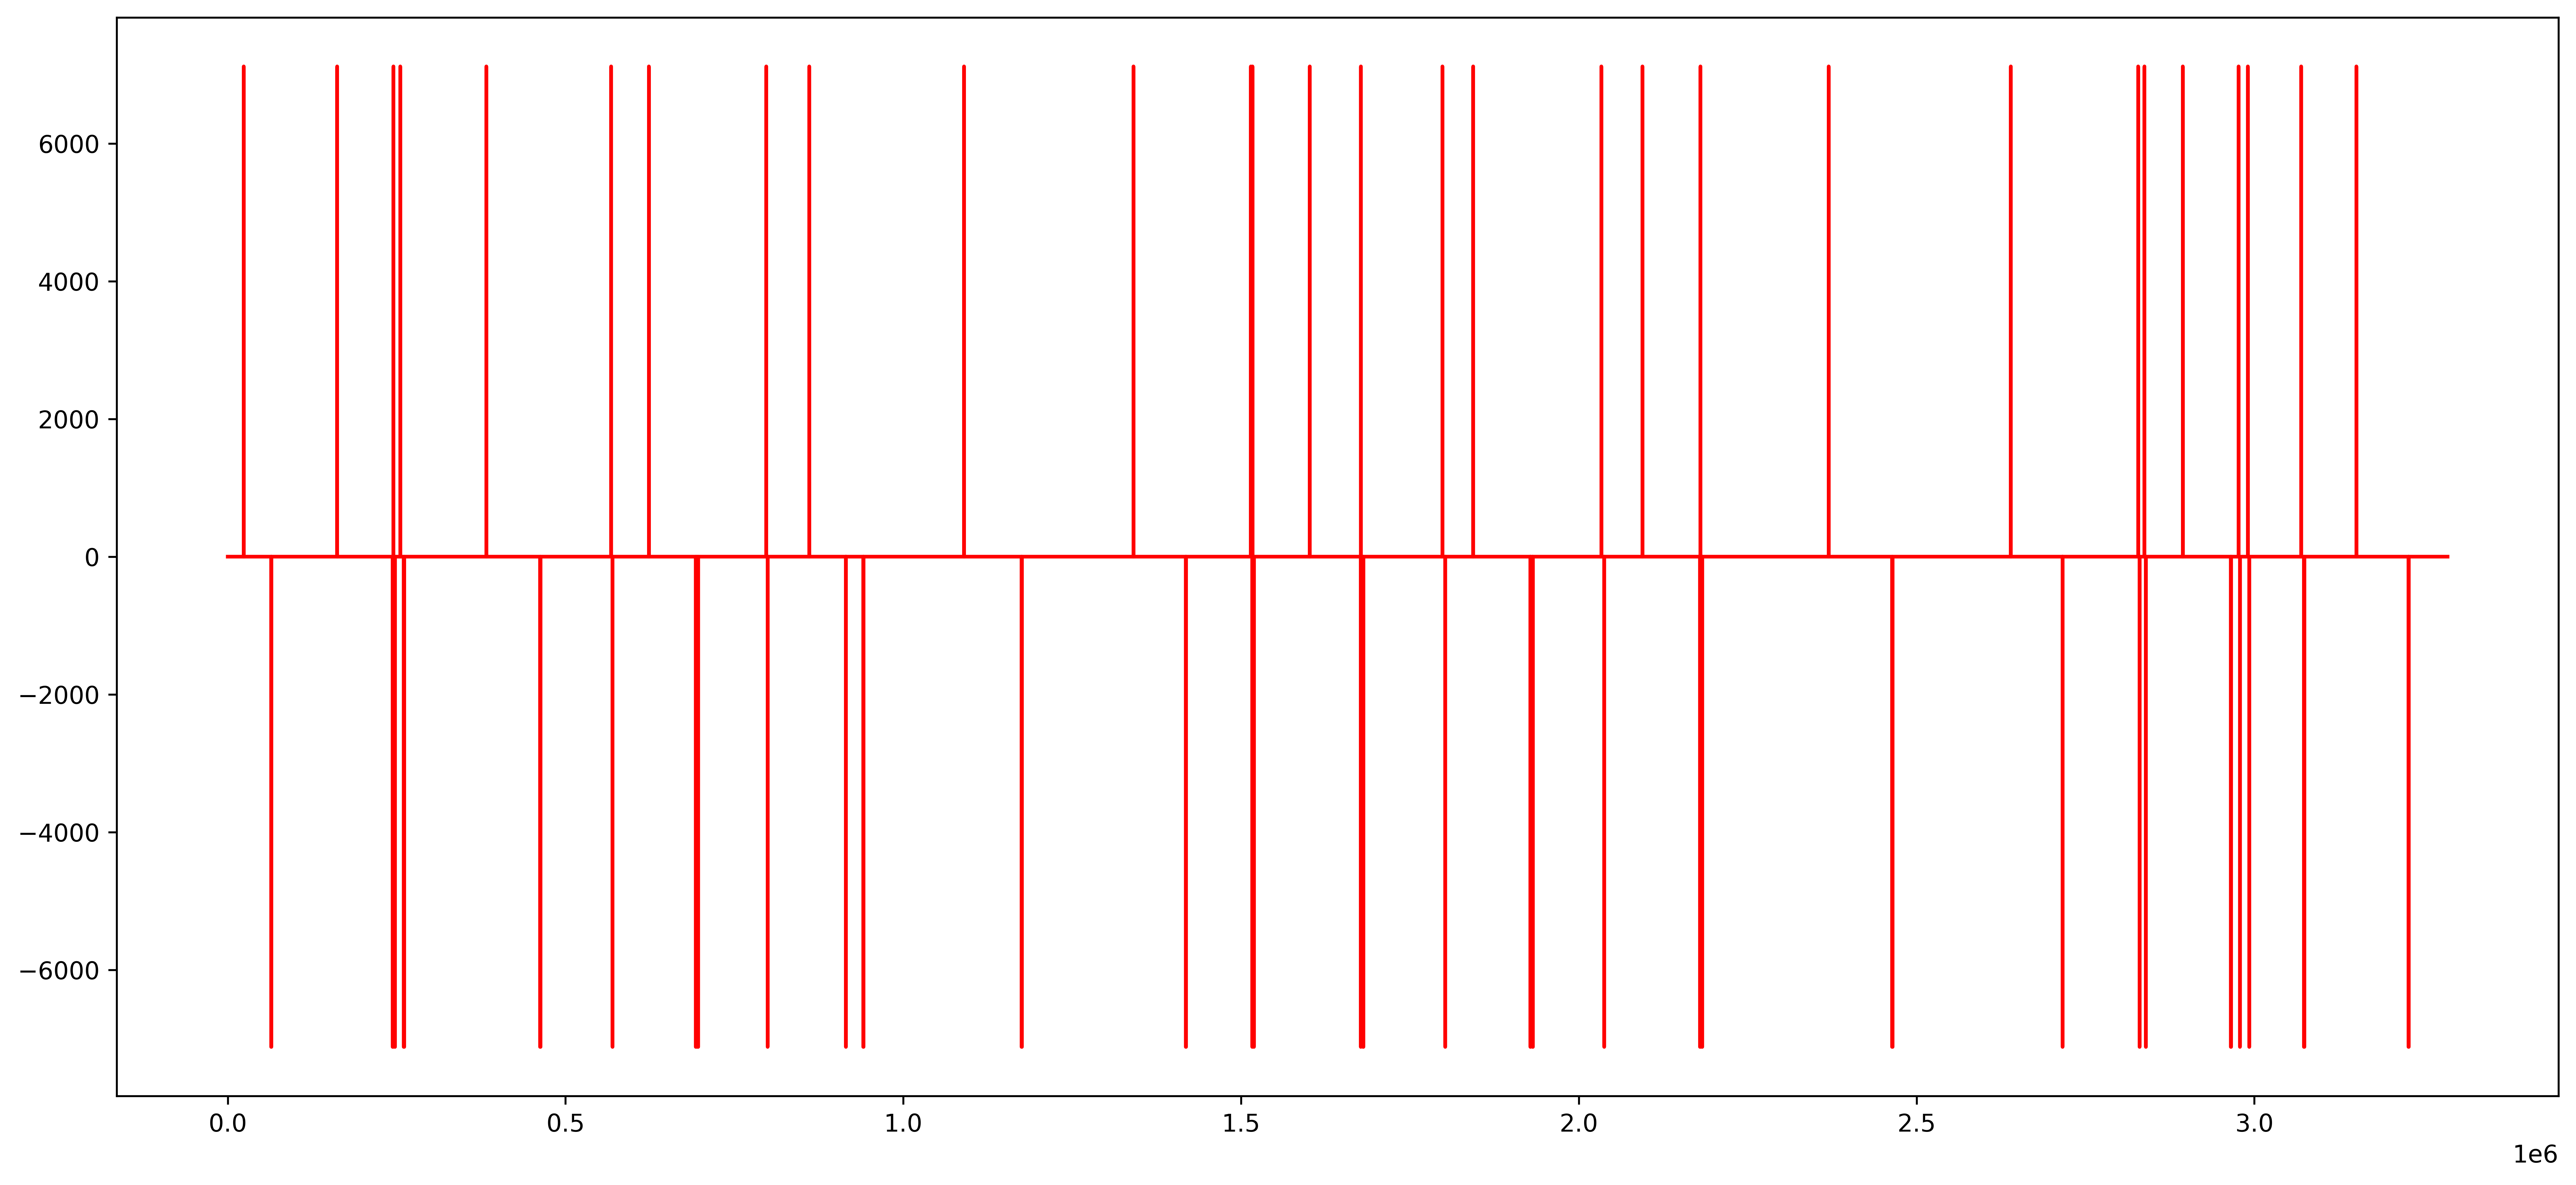

In [7]:
#compare fast and slow
print(block_signal_on_slow==block_signal_on)
print(len(block_signal_on))
print(len(block_signal_on_slow))
err=0
plt.figure(figsize=FIG_SIZE,dpi=600)
diff_list=block_signal_on.copy()
for i in range(len(block_signal_on)):
    diff_list[i]-=block_signal_on_slow[i]
    if diff_list[i]!=0:
        err+=1
print(err)
plt.plot(diff_list, 'r')



Identify periods of activity start and end

In [8]:
signal_on_periods=[]
period_start=-1
period_end=-1
for i in range(len(block_signal_on)):
    if block_signal_on[i]!=0:
        if period_start==-1:
            period_start=i
    else:
        if period_start!=-1 and period_end==-1:
            period_end = i
            signal_on_periods.append(tuple([period_start, period_end]))
            period_start=period_end=-1

Method 2: detecting and counting energy

In [20]:
def sinfunc(t, A, w, p, c):
    return A * numpy.sin(w*t + p) + c
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [22]:
SHOW_FIGURES

False

Speeding up Rolling Standard Deviation [Calculations](https://stackoverflow.com/questions/71594436/is-there-a-fast-running-rolling-standard-deviation-algorithm)

In [31]:
from collections import deque
from math import sqrt

class RunningStd:
    def __init__(self, n, initial_window_data):
        self.n = n
        self.data = deque(initial_window_data, maxlen=n)
        self.mean = np.mean(self.data)
        self.sdev = np.std(self.data)
        self.variance = self.sdev * self.sdev

    def add(self, x):
        n = self.n
        oldmean = self.mean
        goingaway = self.data[0]
        self.mean = newmean = oldmean + (x - goingaway) / n
        self.data.append(x)
        self.variance += (x - goingaway) * (
            (x - newmean) + (goingaway - oldmean)) / (n - 1)
        self.sdev = sqrt(self.variance)

In [33]:
type(one_sample)

array.array

In [34]:
all_result_dict = {}
period_index = 0
i=0
initial_window_size=INITIAL_WINDOW_SIZE
for period_start, period_end in signal_on_periods:
    try:
        one_result_dict = {}
        one_result_dict['start'] = period_start
        one_result_dict['end'] = period_end
        one_sample = samples[period_start:period_end]
        running_std_obj=RunningStd(INITIAL_WINDOW_SIZE, one_sample[:INITIAL_WINDOW_SIZE])


        if SHOW_FIGURES:
            plt.figure(figsize=FIG_SIZE)
            plt.plot(one_sample, alpha=0.5)

        # if you want to listen to the segment, uncomment the lines below:
        # 1000 here because it is in milliseconds
        # seg = sound[period_start/original_sample_rate*1000:period_end/original_sample_rate*1000]
        # play(seg)

        one_sample_series=pd.Series(one_sample)
        # calculate the standard deviation
        #periods with sound of ball hitting wall have high variance in values
        def func1(x):
            running_std_obj.add(x)
            return running_std_obj.sdev

        start_time=time.time()
        rolling_res=one_sample_series.rolling(window=initial_window_size).apply(func1)
        print('calc rolling time:', time.time()-start_time)

        if SHOW_FIGURES:
            plt.plot(rolling_res, color='green', alpha=1, label='rolling_res')
            plt.legend(loc="upper left")
            plt.show()

        # fit sine wave
        if SHOW_FIGURES:
            fig, ax = plt.subplots(figsize=FIG_SIZE)
        data_to_fit=rolling_res
        # filling na data
        data_to_fit=data_to_fit.fillna(np.mean(data_to_fit))
        # standardizing the data to make it easier for fitting signal to identify it
        dataMean = np.mean(data_to_fit)
        dataStd=np.std(data_to_fit)
        data_to_fit_standardized=(data_to_fit-dataMean)/dataStd
        if SHOW_FIGURES:
            ax.plot(data_to_fit_standardized, color='red',
                    alpha=0.4, label='data_to_fit_standardized')

        # shift the data to be around the x axis
        def func2(x):
            return x[0]-np.mean(x)
        data_to_fit_standardized_shifted = data_to_fit_standardized.rolling(window=initial_window_size).apply(func2, raw=True)
        if SHOW_FIGURES:
            ax.plot(data_to_fit_standardized_shifted, color='blue',
                    alpha=1, label='data_to_fit_standardized_shifted')
        x_vals = np.linspace(0, len(data_to_fit_standardized_shifted)-1,
                            num=len(data_to_fit_standardized_shifted))
        x_vals_test = np.linspace(0, len(data_to_fit_standardized_shifted)-1,
                                num=100 * len(data_to_fit_standardized))
        # replace na values
        ds_mean = data_to_fit_standardized_shifted.mean()
        data_to_fit_standardized_shifted.fillna(value=ds_mean, inplace=True)
        res = fit_sin(x_vals, data_to_fit_standardized_shifted)
        if SHOW_DEBUG_MESSAGES:
            print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )
        if SHOW_FIGURES:
            plt.plot(x_vals_test, res["fitfunc"](x_vals_test), "r-", label="y fit curve", linewidth=2)
            ax.legend(loc='best')
            ax.grid(True, which='both')
            plt.show()

        # should I add this to the result:
        this_period_freq = res['omega']/(2*np.pi)
        this_period_bounce_count = int(
            this_period_freq*(period_end-period_start))
        if this_period_bounce_count > MINIMUM_BOUNCES_TO_ADD_TO_RESULTS:
            one_result_dict['period_index'] = period_index
            one_result_dict['the_freq'] = this_period_freq
            one_result_dict['bounce_count'] = int(
                one_result_dict['the_freq']*(period_end-period_start))
            one_result_dict['period_duration'] = (
                period_end-period_start)/original_sample_rate
            if SHOW_DEBUG_MESSAGES:
                print('The bouncing frequency:', one_result_dict['the_freq'], end='\t')
                print('Period bounce count:', one_result_dict['bounce_count'], end='\t')
                print('Period duration:', one_result_dict['period_duration'])
            all_result_dict[period_index] = one_result_dict.copy()
            period_index += 1
            #doing one period now to speed up calculations

            break

    except Exception as error:
        print("An error has occured: ", error)

In [29]:
print(len(rolling_res), len(one_sample_series))

82096 82096


In [26]:
period_index

1

Export to Excel file

In [8]:
all_df=pd.DataFrame()
for period_index, period_details in all_result_dict.items():
    if all_df.size==0:
        all_df = pd.DataFrame(data=period_details, index=[0])
    else:
        one_df=pd.DataFrame(data=period_details, index=[0])
        all_df=pd.concat([all_df,one_df])

all_df.to_excel('./'+FILE_NAME+'Ball_Bounces.xlsx')


#### Appendix and helper functions

One Sample audio file

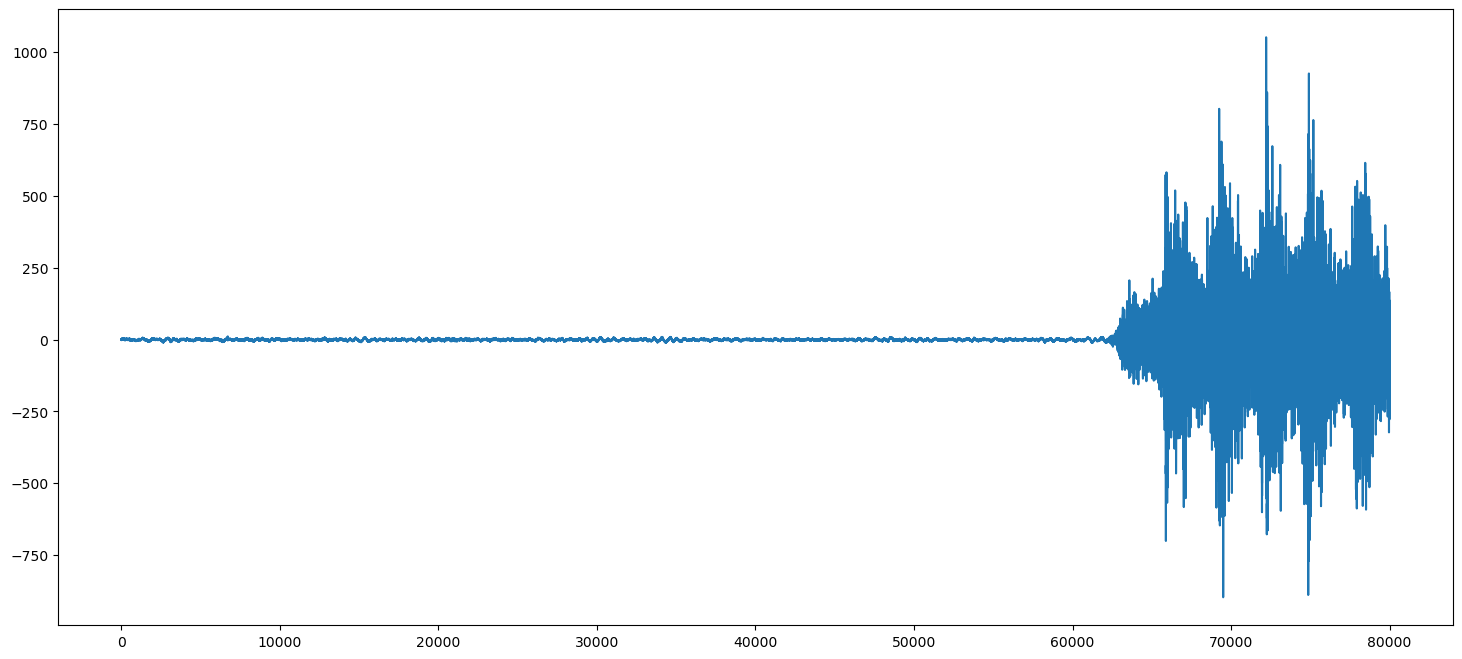

In [9]:
one_sample=samples[100000:180000]
short_sound = AudioSegment(one_sample.tobytes(), frame_rate=sound.frame_rate,sample_width=sound.sample_width,channels=1)
file_handle = short_sound.export("short_sound_output.wav", format="wav")
plt.figure(figsize=FIG_SIZE)
plt.plot(one_sample)

Slow down file to count bounces and update model

In [10]:
def speed_change(sound, speed=1.0):
    # Manually override the frame_rate. This tells the computer how many
    # samples to play per second
    sound_with_altered_frame_rate = sound._spawn(sound.raw_data, overrides={
        "frame_rate": int(sound.frame_rate * speed)
    })

    # convert the sound with altered frame rate to a standard frame rate
    # so that regular playback programs will work right. They often only
    # know how to play audio at standard frame rate (like 44.1k)
    return sound_with_altered_frame_rate.set_frame_rate(sound.frame_rate)

In [11]:
slow_sound = speed_change(sound, 0.1)
file_handle = slow_sound.export(FILE_NAME_ONLY+"_SLOWED_DOWN.wav", format="wav")